<a href="https://colab.research.google.com/github/utsabsarkar12/Machine_Learning/blob/main/AIRBNB_PRICE_PREDICTION_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.utils import resample
warnings.filterwarnings("ignore")
np.random.seed(42)

In [2]:
LISTING_PATH = Path("/content/listings.csv")
REVIEWS_PATH = Path("/content/reviews.csv")
CALENDAR_PATH = Path("/content/calendar.csv")

for p in [LISTING_PATH, REVIEWS_PATH, CALENDAR_PATH]:
    if not p.exists():
        raise FileNotFoundError(f"{p} not found. Upload the three csvs to the specified paths.")

# 1. Data Loading
listing = pd.read_csv(LISTING_PATH, low_memory=False)
reviews = pd.read_csv(REVIEWS_PATH, low_memory=False)
calendar = pd.read_csv(CALENDAR_PATH, low_memory=False)

print("Loaded shapes:")
print("listing:", listing.shape)
print("reviews:", reviews.shape)
print("calendar:", calendar.shape)

# Helper: clean price like "$1,234.00" -> 1234.0
def clean_price(col):
    return pd.to_numeric(col.astype(str).str.replace(r'[$,]', '', regex=True).str.strip().replace('', np.nan), errors='coerce')

# Ensure price numeric
if 'price' not in listing.columns:
    raise KeyError("'price' column not found in listing.csv")
listing['price'] = clean_price(listing['price'])

Loaded shapes:
listing: (3818, 92)
reviews: (84849, 6)
calendar: (1393570, 4)


In [3]:
# 2-3. Data exploration: number of records/features and per-column summary
print("\n=== Listing dataset summary ===")
print("Rows:", listing.shape[0], "Cols:", listing.shape[1])
print("\nData types:\n", listing.dtypes.value_counts())
missing = listing.isna().sum().to_frame('missing_count')
missing['missing_pct'] = 100 * missing['missing_count'] / len(listing)
print("\nTop 20 columns by missing values:")
display(missing.sort_values('missing_count', ascending=False).head(20))

# Quick first rows
print("\nSample rows:")
display(listing.head(3))


=== Listing dataset summary ===
Rows: 3818 Cols: 92

Data types:
 object     61
float64    18
int64      13
Name: count, dtype: int64

Top 20 columns by missing values:


,missing_count,missing_pct
license,3818,100.000000
square_feet,3721,97.459403
monthly_price,2301,60.267156
security_deposit,1952,51.126244
weekly_price,1809,47.380828
notes,1606,42.063908
neighborhood_overview,1032,27.029859
cleaning_fee,1030,26.977475
transit,934,24.463070
host_about,859,22.498690



Sample rows:


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15


Merged reviews_count into listing.
Merged availability_rate into listing.


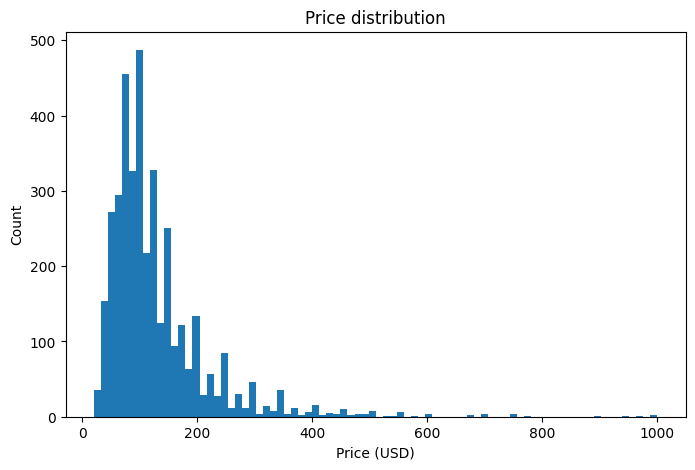

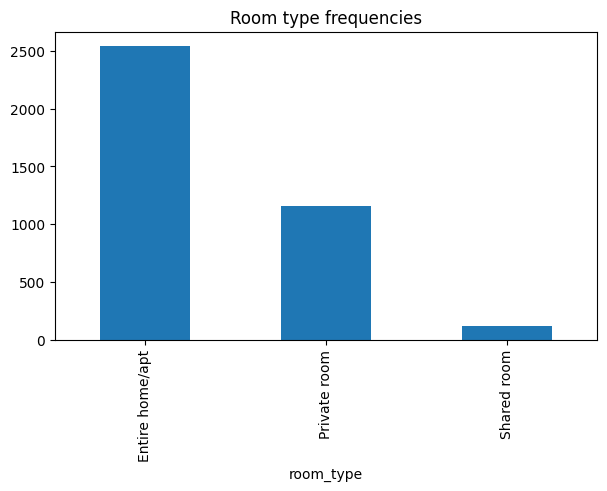

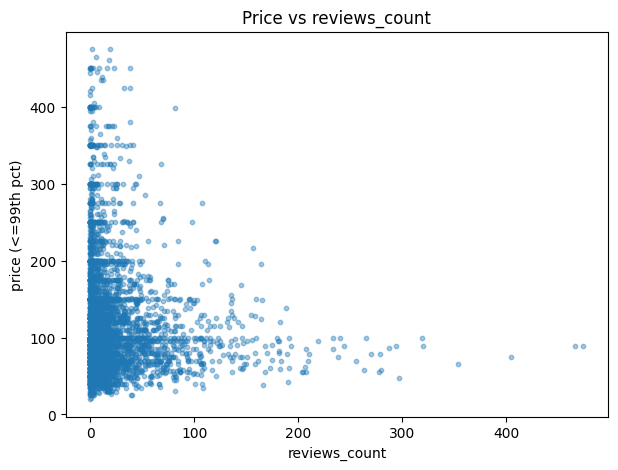

In [4]:
# 4. Aggregate reviews & calendar and merge
# reviews: expected 'listing_id' column; count reviews per listing
if 'listing_id' in reviews.columns:
    rev_agg = reviews.groupby('listing_id').agg(reviews_count=('id', 'count')).reset_index()
    listing = listing.merge(rev_agg, how='left', left_on='id', right_on='listing_id')
    listing['reviews_count'] = listing['reviews_count'].fillna(0)
    listing.drop(columns=['listing_id'], inplace=True, errors=True)
    print("Merged reviews_count into listing.")
else:
    print("reviews.csv missing 'listing_id' column; skipping reviews merge.")

# calendar: expected 'listing_id' and 'available' columns -> compute availability_rate
if {'listing_id','available'}.issubset(calendar.columns):
    def avail_count(g):
        # consider 't' as available
        return (g['available'].astype(str) == 't').sum()
    cal_agg = calendar.groupby('listing_id').agg(total_days=('date','count'), available_days=('available', lambda s: (s.astype(str)=='t').sum())).reset_index()
    cal_agg['availability_rate'] = cal_agg['available_days'] / cal_agg['total_days']
    listing = listing.merge(cal_agg[['listing_id','availability_rate']], how='left', left_on='id', right_on='listing_id')
    listing['availability_rate'] = listing['availability_rate'].fillna(listing['availability_rate'].median())
    listing.drop(columns=['listing_id'], inplace=True, errors=True)
    print("Merged availability_rate into listing.")
else:
    print("calendar.csv missing expected columns; skipping calendar merge.")


# 4. Visualizations
plt.figure(figsize=(8,5))
plt.hist(listing['price'].dropna(), bins=80)
plt.title("Price distribution")
plt.xlabel("Price (USD)")
plt.ylabel("Count")
plt.show()

if 'room_type' in listing.columns:
    plt.figure(figsize=(7,4))
    listing['room_type'].value_counts().plot(kind='bar')
    plt.title("Room type frequencies")
    plt.show()

if 'reviews_count' in listing.columns:
    tmp = listing[['price','reviews_count']].dropna()
    cap = tmp['price'].quantile(0.99)
    tmp = tmp[tmp['price'] <= cap]
    plt.figure(figsize=(7,5))
    plt.scatter(tmp['reviews_count'], tmp['price'], s=10, alpha=0.4)
    plt.xlabel("reviews_count")
    plt.ylabel("price (<=99th pct)")
    plt.title("Price vs reviews_count")
    plt.show()

In [6]:
# 5. Preprocessing
# Drop identifiers and long text fields (common in Airbnb dataset)
drop_cols = [
    'listing_url','scrape_id','last_scraped','name','summary','space','description',
    'neighborhood_overview','notes','transit','access','interaction','house_rules',
    'thumbnail_url','medium_url','picture_url','xl_picture_url','host_about','host_picture_url',
    'calendar_updated','first_review','last_review','license'
]
drop_cols = [c for c in drop_cols if c in listing.columns]
df = listing.drop(columns=drop_cols).copy()

# Remove rows missing target
df = df.dropna(subset=['price']).reset_index(drop=True)

# Convert obvious boolean strings to numeric
for c in df.select_dtypes(include=['object']).columns:
    vals = set(df[c].dropna().astype(str).str.lower().unique())
    if vals.issubset({'t','f','true','false','yes','no'}):
        df[c] = df[c].astype(str).str.lower().map({'t':1,'true':1,'yes':1,'f':0,'false':0,'no':0})

# Try coerce object columns to numeric if many values become numeric
for c in df.columns:
    if df[c].dtype == 'object':
        coerced = pd.to_numeric(df[c].str.replace(r'[$,]', '', regex=True), errors='coerce')
        if coerced.notna().mean() > 0.7:
            df[c] = coerced

# Identify numeric & categorical (exclude price)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'price' in numeric_cols:
    numeric_cols.remove('price')
categorical_cols = [c for c in df.columns if c not in numeric_cols + ['price']]
print("\nFeatures selected:", len(numeric_cols), "numeric;", len(categorical_cols), "categorical (capped later).")

# Limit OHE to small/medium cardinality categorical columns
selected_cats = []
for c in categorical_cols:
    nunique = df[c].nunique(dropna=True)
    if 1 < nunique <= 50:
        selected_cats.append(c)
# keep only first 10 to avoid huge OHE in exam setting
selected_cats = selected_cats[:10]
print("Categorical columns to one-hot encode (<=50 unique, up to 10):", selected_cats)

# Preprocessing pipelines
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Handle compatibility: sklearn >= 1.2 uses sparse_output, older uses sparse
try:
    cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
except TypeError:
    cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_cols),
    ('cat', cat_pipe, selected_cats)
])

# Train-test split
X = df.drop(columns=['price'])
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train/test split:", X_train.shape, X_test.shape)


Features selected: 42 numeric; 31 categorical (capped later).
Categorical columns to one-hot encode (<=50 unique, up to 10): ['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'neighbourhood_group_cleansed', 'city', 'state', 'smart_location', 'property_type', 'room_type', 'bed_type']
Train/test split: (3054, 73) (764, 73)


In [7]:
# 6-7. Model training & hyperparameter tuning
models = {
    'Linear Regression': Pipeline([('pre', preprocessor), ('model', LinearRegression())]),
    'SVR': Pipeline([('pre', preprocessor), ('model', SVR())]),
    'Decision Tree': Pipeline([('pre', preprocessor), ('model', DecisionTreeRegressor(random_state=42))])
}

param_grids = {
    'Linear Regression': None,
    'SVR': {
        'model__kernel': ['rbf'],
        'model__C': [1, 5],
        'model__gamma': ['scale', 0.01],
        'model__epsilon': [0.1, 0.2]
    },
    'Decision Tree': {
        'model__max_depth': [6, 10, None],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 5]
    }
}

fitted = {}
best_params = {}
for name, pipe in models.items():
    print(f"\nTraining {name} ...")
    if param_grids[name] is None:
        pipe.fit(X_train, y_train)
        fitted[name] = pipe
        best_params[name] = 'N/A (OLS)'
    else:
        grid = GridSearchCV(pipe, param_grids[name], cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, refit=True)
        grid.fit(X_train, y_train)
        fitted[name] = grid.best_estimator_
        best_params[name] = grid.best_params_
    print(name, "best params:", best_params[name])


Training Linear Regression ...
Linear Regression best params: N/A (OLS)

Training SVR ...
SVR best params: {'model__C': 5, 'model__epsilon': 0.1, 'model__gamma': 0.01, 'model__kernel': 'rbf'}

Training Decision Tree ...
Decision Tree best params: {'model__max_depth': 6, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2}


In [8]:
# 8. Training evaluation metrics
def eval_reg(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

train_results = []
for name, model in fitted.items():
    y_tr = model.predict(X_train)
    mae, mse, rmse = eval_reg(y_train, y_tr)
    train_results.append({'Model':name, 'Train MAE':mae, 'Train MSE':mse, 'Train RMSE':rmse})
train_df = pd.DataFrame(train_results).sort_values('Train RMSE')
print("\nTraining metrics:")
display(train_df)


Training metrics:


,Model,Train MAE,Train MSE,Train RMSE
2,Decision Tree,32.910504,2837.278444,53.266110
0,Linear Regression,33.581758,3174.141755,56.339522
1,SVR,33.912462,4180.704089,64.658364


In [9]:
# 9. Testing evaluation + bootstrap 95% CIs
def bootstrap_ci(model, Xtest, ytest, B=300):
    rng = np.random.RandomState(42)
    maes, mses, rmses = [], [], []
    n = len(ytest)
    Xtest = Xtest.reset_index(drop=True)
    ytest = ytest.reset_index(drop=True)
    for b in range(B):
        idx = rng.randint(0, n, n)
        Xb = Xtest.iloc[idx]
        yb = ytest.iloc[idx]
        ypred = model.predict(Xb)
        m1, m2, m3 = eval_reg(yb, ypred)
        maes.append(m1); mses.append(m2); rmses.append(m3)
    def mean_ci(arr):
        arr = np.array(arr)
        return arr.mean(), (np.percentile(arr,2.5), np.percentile(arr,97.5))
    return {'MAE':mean_ci(maes), 'MSE':mean_ci(mses), 'RMSE':mean_ci(rmses)}

test_results = []
for name, model in fitted.items():
    y_pred = model.predict(X_test)
    mae, mse, rmse = eval_reg(y_test, y_pred)
    stats = bootstrap_ci(model, X_test, y_test, B=300)
    test_results.append({
        'Model': name,
        'Test MAE': mae, 'Boot MAE Mean': stats['MAE'][0], 'Boot MAE CI': stats['MAE'][1],
        'Test MSE': mse, 'Boot MSE Mean': stats['MSE'][0], 'Boot MSE CI': stats['MSE'][1],
        'Test RMSE': rmse, 'Boot RMSE Mean': stats['RMSE'][0], 'Boot RMSE CI': stats['RMSE'][1]
    })

test_df = pd.DataFrame(test_results).sort_values('Test RMSE')
print("\nTesting metrics (with bootstrapped 95% CIs):")
display(test_df)


Testing metrics (with bootstrapped 95% CIs):


,Model,Test MAE,Boot MAE Mean,Boot MAE CI,Test MSE,Boot MSE Mean,Boot MSE CI,Test RMSE,Boot RMSE Mean,Boot RMSE CI
2,Decision Tree,35.685204,35.688958,"(32.872148948016715, 38.88264842025619)",3091.782694,3111.685146,"(2392.4324757539844, 3982.9178381622382)",55.603801,55.653728,"(48.912443893336956, 63.11033291717592)"
0,Linear Regression,35.485572,35.532022,"(32.119210929457715, 38.48582361330539)",3144.126235,3166.862345,"(2298.4028989868925, 4094.286235317802)",56.072509,56.120398,"(47.941661292982474, 63.9858322780064)"
1,SVR,33.984505,33.964298,"(30.178630314923726, 37.51883412258617)",3758.240534,3777.897237,"(2496.854549857831, 4983.276244904372)",61.304490,61.240021,"(49.96765980270452, 70.59229109381312)"



Model comparison (train vs test):


,Model,Train MAE,Train MSE,Train RMSE,Test MAE,Test MSE,Test RMSE,RMSE Gap
0,Decision Tree,32.910504,2837.278444,53.266110,35.685204,3091.782694,55.603801,2.337691
1,Linear Regression,33.581758,3174.141755,56.339522,35.485572,3144.126235,56.072509,-0.267013
2,SVR,33.912462,4180.704089,64.658364,33.984505,3758.240534,61.304490,-3.353874


Best model: Decision Tree


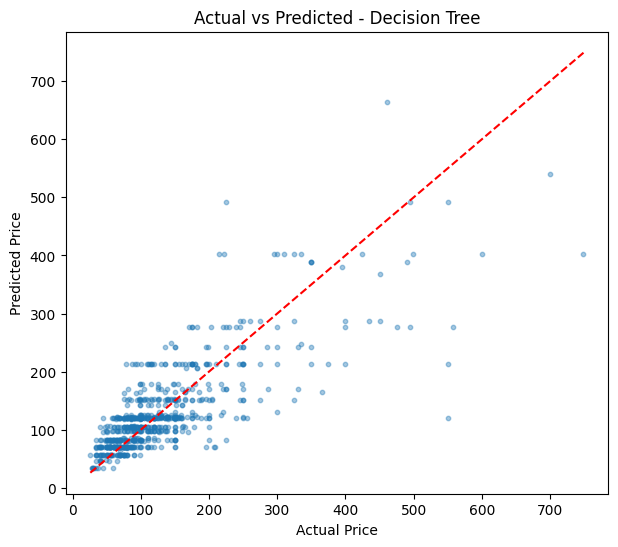


Done. Summary:
- best_params: {'Linear Regression': 'N/A (OLS)', 'SVR': {'model__C': 5, 'model__epsilon': 0.1, 'model__gamma': 0.01, 'model__kernel': 'rbf'}, 'Decision Tree': {'model__max_depth': 6, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2}}
- Check the 'comparison' table above for RMSE gaps (train->test) to identify overfitting.


In [10]:
# 10. Model comparison & overfitting/underfitting check
comparison = train_df.merge(test_df[['Model','Test MAE','Test MSE','Test RMSE']], on='Model')
comparison['RMSE Gap'] = comparison['Test RMSE'] - comparison['Train RMSE']
print("\nModel comparison (train vs test):")
display(comparison.sort_values('Test RMSE'))

# Residual plot for best model (lowest Test RMSE)
best_model_name = test_df.iloc[0]['Model']
print("Best model:", best_model_name)
best_model = fitted[best_model_name]
y_pred_best = best_model.predict(X_test)
plt.figure(figsize=(7,6))
plt.scatter(y_test, y_pred_best, s=10, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(f"Actual vs Predicted - {best_model_name}")
plt.show()

print("\nDone. Summary:")
print("- best_params:", best_params)
print("- Check the 'comparison' table above for RMSE gaps (train->test) to identify overfitting.")